## Prelimiary Operations

### Useful operations

In [1]:
import os
import shutil
if os.path.exists("/kaggle/working/andrea"):
    shutil.rmtree("/kaggle/working/andrea")

In [2]:
if os.path.exists("/kaggle/working/EfficientNet_experiments"):
    shutil.rmtree("/kaggle/working/EfficientNet_experiments")

In [3]:
if os.path.exists("/kaggle/working/EfficientNet"):
    shutil.rmtree("/kaggle/working/EfficientNet")

In [4]:
# to remove a file
import os
if os.path.exists("/kaggle/working/model.png"):
    os.remove("/kaggle/working/model.png")

In [5]:
# to create a folder
import os
directory = "EfficientNet"
parent_dir = "/kaggle/working"
path = os.path.join(parent_dir, directory)
if not os.path.exists(path):
    os.mkdir(path)

### Operations

In [6]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers

In [7]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [8]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Importing data

In [9]:
labels = {
    0: 'Species1', # 0
    1: 'Species2', # 1
    2: 'Species3', # 2
    3: 'Species4', # 3
    4: 'Species5', # 4
    5: 'Species6', # 5
    6: 'Species7', # 6
    7: 'Species8'} # 7

In [10]:
# Dataset folders 
dataset_dir = "../input/splitted-dataset-no-test/splitted_dataset_no_test"
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')

In [ ]:
img_height = 96
img_width =96
batch_size = 32

In [ ]:
training_dataset = tfk.preprocessing.image_dataset_from_directory(training_dir, label_mode='categorical', image_size=(img_height, img_width))
validation_dataset = tfk.preprocessing.image_dataset_from_directory(validation_dir, label_mode='categorical', image_size=(img_height, img_width))

In [11]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator, and for the trainign with Data Augmentation


# Use this for data augmentation
train_data_gen = ImageDataGenerator(rotation_range=40,
                                        height_shift_range=0.5,
                                        width_shift_range=0.5,
                                        zoom_range=0.5,
                                        horizontal_flip=True,
                                        fill_mode='reflect')


# Use this for no augmentation
#train_data_gen = ImageDataGenerator()
valid_data_gen = ImageDataGenerator()

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=8,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)

Found 3432 images belonging to 8 classes.
Found 864 images belonging to 8 classes.


In [ ]:
X_train = None
y_train = None
for images, labels in training_dataset.as_numpy_iterator():
    t_img = tf.constant(images)
    if X_train is not None:
        X_train = tf.concat([X_train,t_img], axis=0)
        y_train = np.concatenate((y_train,labels), axis=0)
    else:
        X_train = t_img
        y_train = labels
print(X_train.shape)
print(y_train.shape)

In [ ]:
X_val = None
y_val = None
for images, labels in validation_dataset.as_numpy_iterator():
    t_img = tf.constant(images)
    if X_val is not None:
        X_val = tf.concat([X_val,t_img], axis=0)
        y_val = np.concatenate((y_val,labels), axis=0)
    else:
        X_val = t_img
        y_val = labels
print(X_val.shape)
print(y_val.shape)

## Model

In [12]:
!cd /kaggle/working/EfficieNet

/bin/bash: line 0: cd: /kaggle/working/EfficieNet: No such file or directory


In [14]:
# Download and plot the EfficientNet model
eff_net = tfk.applications.efficientnet.EfficientNetB3(
    include_top=False,
    weights='imagenet',
    input_shape=(96,96,3),
)

eff_net.trainable = True # we are freezing the weights of the conv part, so that they are not updated
                            # during the training
#tfk.utils.plot_model(eff_net)

43950080/43941136 [==============================] - 2s 0us/step


In [15]:
input_shape = (96, 96, 3)
epochs = 300
learning_rate = 1e-4
l1=1e-4
l2=1e-3

In [16]:
# Load the model of the v7 notebook of efficient net. Otherwise it won't run
# Change load folder
eff_net_model = tfk.models.load_model("/kaggle/input/efficient-net-pretrained-128-dense-augmentation/efficient_net_pretrained_128_dense_more_augmentation")
eff_net_model.summary()

Model: "efficient_net_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 3, 3, 1536)        10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)         

In [17]:
eff_net = eff_net_model.get_layer("efficientnetb3")
eff_net.trainable=False
out_cs = eff_net_model.get_layer("dense")
out_cs.trainable=False

In [18]:
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(input_shape)
    efficient_net_layer = eff_net(input_layer)    
    x = tfkl.GlobalAveragePooling2D()(efficient_net_layer)
    x = tfkl.Dropout(0.3, seed=seed)(x)
    x = tfkl.Dense(128, activation='relu', kernel_initializer=tfk.initializers.HeUniform(seed), kernel_regularizer=tfk.regularizers.L1L2(l1=l1, l2=l2))(x)
    x = tfkl.Dropout(0.3, seed=seed)(x)
    output_layer = tfkl.Dense(8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed))(x)
        # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='efficient_net_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate), metrics='accuracy')

    # Return the model
    return model

Model: "efficient_net_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 3, 3, 1536)        10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)         

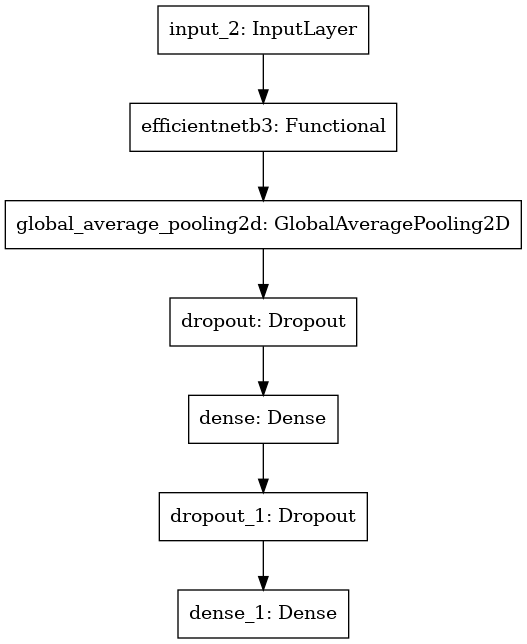

In [19]:
# Build model. Train only the very last layer.
model_name = "Efficient_net_B3_loaded_128_dense"

#eff_net_model = build_model(input_shape)
eff_net_model.summary()
tfk.utils.plot_model(eff_net_model)

In [20]:
patience = 20

In [21]:
# Train the model.
eff_net_model_history = eff_net_model.fit(
    x = train_gen,
    batch_size = 256,
    epochs = epochs,
    validation_data = valid_gen,
    # The callbacks here stop on the minimum of the loss, instead of the maximum of the accuracy
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=patience, restore_best_weights=True)],
).history

Epoch 1/300
429/429 [==============================] - 85s 172ms/step - loss: 0.4885 - accuracy: 0.9403 - val_loss: 0.6718 - val_accuracy: 0.8900
Epoch 2/300
429/429 [==============================] - 65s 152ms/step - loss: 0.4616 - accuracy: 0.9438 - val_loss: 0.6754 - val_accuracy: 0.8877
Epoch 3/300
429/429 [==============================] - 65s 152ms/step - loss: 0.4501 - accuracy: 0.9452 - val_loss: 0.6154 - val_accuracy: 0.8993
Epoch 4/300
429/429 [==============================] - 65s 152ms/step - loss: 0.4327 - accuracy: 0.9484 - val_loss: 0.6353 - val_accuracy: 0.8889
Epoch 5/300
429/429 [==============================] - 66s 153ms/step - loss: 0.4216 - accuracy: 0.9452 - val_loss: 0.6131 - val_accuracy: 0.8912
Epoch 6/300
429/429 [==============================] - 66s 153ms/step - loss: 0.4045 - accuracy: 0.9496 - val_loss: 0.5962 - val_accuracy: 0.8970
Epoch 7/300
429/429 [==============================] - 66s 153ms/step - loss: 0.4048 - accuracy: 0.9467 - val_loss: 0.5602 -

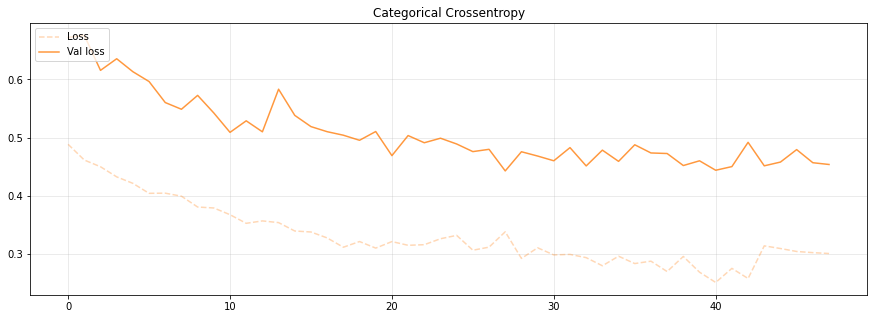

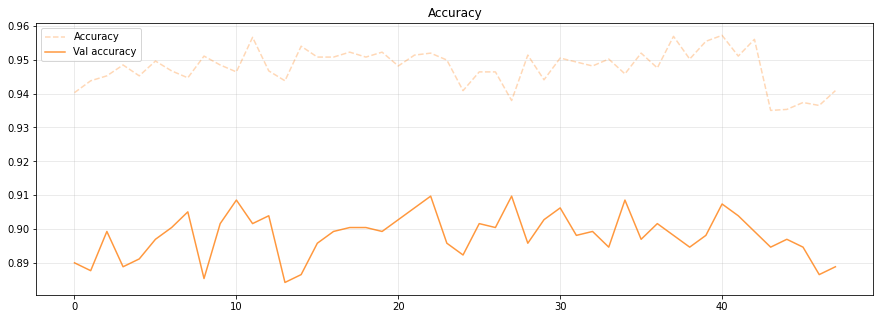

In [22]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(eff_net_model_history['loss'], label='Loss', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(eff_net_model_history['val_loss'], label='Val loss', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)
plt.savefig(model_name + "cat_cr_en.png")

plt.figure(figsize=(15,5))
plt.plot(eff_net_model_history['accuracy'], label='Accuracy', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(eff_net_model_history['val_accuracy'], label='Val accuracy', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)
plt.savefig(model_name + "acc.png")

plt.show()

In [ ]:
predictions = eff_net_model.predict(X_val)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [23]:
# Save the best model
eff_net_model.save(model_name)

In [24]:
# Make zip archive for download
import shutil
name = "/kaggle/working/EfficientNet/" + model_name
shutil.make_archive(name, 'zip', "/kaggle/working/EfficientNet")

'/kaggle/working/EfficientNet/Efficient_net_B3_loaded_128_dense.zip'